In [51]:
import goodfire
from openai import OpenAI
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import Gridspec
from matplotlib.gridspec import GridSpec
load_dotenv()

from steering_test_cases import SAMPLE_STEERING_QUERIES

GOODFIRE_API_KEY = os.getenv("GOODFIRE_API_KEY")

# Checking results

# Results

In [42]:
def plot_all_methods(df: pd.DataFrame, save_path: str = None):
    """
    Create a grid of plots showing point-error plots and score distributions
    for each steering method in the dataframe.
    
    Args:
        df: DataFrame with columns 'steering_method', 'query', 'behavior', 'coherence'
        save_path: Optional path to save the plot
    """
    # Get unique methods
    methods = df['steering_method'].unique()
    n_methods = len(methods)
    
    # Set up the figure with a grid
    # 2 rows (point-error and distributions) x n_methods columns
    fig = plt.figure(figsize=(8*n_methods, 12), dpi=100)
    gs = fig.add_gridspec(2, n_methods)
    
    # Colors
    behavior_color = '#3498db'  # Blue
    coherence_color = '#e67e22'  # Orange
    
    # Plot each method
    for idx, method in enumerate(methods):
        method_df = df[df['steering_method'] == method]
        
        # Point-error plot
        ax_point = fig.add_subplot(gs[0, idx])
        plot_method_point_error(method_df, ax_point, behavior_color, coherence_color)
        
        # Distribution plot
        ax_dist = fig.add_subplot(gs[1, idx])
        plot_method_distributions(method_df, ax_dist, behavior_color, coherence_color)
        
        # Add method title
        ax_point.set_title(f'Method: {method}', pad=20, fontsize=14, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    
    # Show plot
    plt.show()

def plot_method_point_error(df: pd.DataFrame, ax: plt.Axes, behavior_color: str, coherence_color: str):
    """Helper function to create point-error plot for a single method"""
    # Reshape data
    df_melted = pd.melt(df, 
                       id_vars=['query'], 
                       value_vars=['behavior', 'coherence'],
                       var_name='metric', 
                       value_name='score')
    
    # Define query order
    query_order = df_melted['query'].unique()
    df_melted['query'] = pd.Categorical(df_melted['query'], categories=query_order, ordered=True)
    
    # Calculate statistics
    stats = df_melted.groupby(['query', 'metric'])['score'].agg(['mean', 'std']).reset_index()
    stats['query'] = pd.Categorical(stats['query'], categories=query_order, ordered=True)
    stats = stats.sort_values('query')
    
    # Add individual points
    sns.stripplot(x='query', 
                 y='score', 
                 hue='metric',
                 data=df_melted,
                 dodge=True,
                 alpha=0.3,
                 zorder=1,
                 size=4,
                 palette=[behavior_color, coherence_color],
                 jitter=0.2,
                 order=query_order,
                 ax=ax)
    
    # Add error bars
    width = 0.2
    for i, metric in enumerate(['behavior', 'coherence']):
        metric_stats = stats[stats['metric'] == metric]
        offset = width if i == 1 else -width
        color = behavior_color if metric == 'behavior' else coherence_color
        
        ax.errorbar(x=np.arange(len(metric_stats)) + offset,
                   y=metric_stats['mean'],
                   yerr=metric_stats['std'],
                   fmt='o',
                   capsize=5,
                   capthick=2,
                   markersize=8,
                   color=color,
                   elinewidth=2,
                   label=metric)
    
    # Customize plot
    ax.set_xlabel('Query Type', fontsize=10, labelpad=10)
    ax.set_ylabel('Score', fontsize=10, labelpad=10)
    ax.set_ylim(0.5, 5.5)
    ax.set_yticks(range(1, 6))
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Handle legend
    if ax.get_subplotspec().is_last_col():
        ax.legend(title='Metric', title_fontsize=10, fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
    else:
        ax.legend().remove()

def plot_method_distributions(df: pd.DataFrame, ax: plt.Axes, behavior_color: str, coherence_color: str):
    """Helper function to create distribution plots for a single method"""
    # Reshape data
    df_melted = pd.melt(df, 
                       id_vars=['query'], 
                       value_vars=['behavior', 'coherence'],
                       var_name='metric', 
                       value_name='score')
    
    # Create two subplots within the given axes
    divider = make_axes_locatable(ax)
    ax_behavior = ax
    ax_coherence = divider.append_axes("right", size="100%", pad=0.1)
    
    # Plot behavior scores
    behavior_data = df_melted[df_melted['metric'] == 'behavior']['score']
    ax_behavior.hist(behavior_data, bins=np.arange(0.5, 6, 0.5), 
                    color=behavior_color, alpha=0.7, edgecolor='white',
                    orientation='horizontal')
    ax_behavior.axhline(behavior_data.mean(), color='red', linestyle='dashed', linewidth=2,
                       label=f'Mean: {behavior_data.mean():.2f}')
    ax_behavior.set_title('Behavior', pad=20, fontsize=12)
    ax_behavior.set_ylabel('Score', fontsize=10)
    ax_behavior.set_xlabel('Frequency', fontsize=10)
    ax_behavior.set_ylim(0.5, 5.5)
    ax_behavior.set_xlim(0, len(behavior_data))
    ax_behavior.grid(True, alpha=0.3)
    ax_behavior.legend(loc='upper right', fontsize=8)
    
    # Plot coherence scores
    coherence_data = df_melted[df_melted['metric'] == 'coherence']['score']
    ax_coherence.hist(coherence_data, bins=np.arange(0.5, 6, 0.5),
                     color=coherence_color, alpha=0.7, edgecolor='white',
                     orientation='horizontal')
    ax_coherence.axhline(coherence_data.mean(), color='red', linestyle='dashed', linewidth=2,
                        label=f'Mean: {coherence_data.mean():.2f}')
    ax_coherence.set_title('Coherence', pad=20, fontsize=12)
    ax_coherence.set_xlabel('Frequency', fontsize=10)
    ax_coherence.set_ylim(0.5, 5.5)
    ax_coherence.set_xlim(0, len(coherence_data))
    ax_coherence.set_yticklabels([])
    ax_coherence.grid(True, alpha=0.3)
    ax_coherence.legend(loc='upper right', fontsize=8)


In [94]:
def create_method_colors(df):
    """Create a consistent color mapping for methods"""
    methods = sorted(df['steering_method'].unique())  # Sort to ensure consistent order
    colors = sns.color_palette('Set2', n_colors=len(methods))
    # Make the "do_nothing" gray
    colors[methods.index('do_nothing')] = '#95a5a6'
    return dict(zip(methods, colors))

def plot_radar_comparison(df: pd.DataFrame, save_path: str = None):
    """
    Create radar plots comparing behavior and coherence scores across methods.
    
    Args:
        df: DataFrame with columns 'steering_method', 'query', 'behavior', 'coherence'
        save_path: Optional path to save the plot
    """
    # Set up the figure
    fig = plt.figure(figsize=(20, 6))
    gs = GridSpec(1, 2, width_ratios=[1, 1])
    
    # Create axes
    ax_radar_behavior = fig.add_subplot(gs[0], projection='polar')
    ax_radar_coherence = fig.add_subplot(gs[1], projection='polar')
    
    # Create consistent color mapping
    method_colors = create_method_colors(df)
    
    # Plot each metric
    plot_radar_metric(df, 'behavior', ax_radar_behavior, method_colors, show_legend=True)
    plot_radar_metric(df, 'coherence', ax_radar_coherence, method_colors, show_legend=False)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Radar plot saved to {save_path}")
    
    plt.show()

def plot_distribution_comparison(df: pd.DataFrame, save_path: str = None):
    """
    Create distribution plots comparing behavior and coherence scores across methods.
    
    Args:
        df: DataFrame with columns 'steering_method', 'query', 'behavior', 'coherence'
        save_path: Optional path to save the plot
    """
    # Create consistent color mapping
    method_colors = create_method_colors(df)
    
    # Set up the figure
    fig, (ax_behavior, ax_coherence) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot distributions
    plot_violin(df, 'behavior', ax_behavior, method_colors)
    plot_violin(df, 'coherence', ax_coherence, method_colors)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Distribution plot saved to {save_path}")
    
    plt.show()

def plot_radar_metric(df: pd.DataFrame, metric: str, ax: plt.Axes, method_colors, show_legend=False):
    """Helper function to create radar plot for a specific metric"""
    # Calculate mean and std scores per query and method
    means = df.groupby(['query', 'steering_method'])[metric].mean().unstack()
    stds = df.groupby(['query', 'steering_method'])[metric].std().unstack()
    
    # Set up the angles for the radar chart
    num_queries = len(means.index)
    angles = np.linspace(0, 2 * np.pi, num_queries, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Close the plot
    
    # Plot each method
    for method in sorted(means.columns):  # Sort to ensure consistent order
        values = means[method].values
        std_values = stds[method].values
        
        # Close the values
        values = np.concatenate((values, [values[0]]))
        std_values = np.concatenate((std_values, [std_values[0]]))
        
        # Plot mean line using consistent color mapping
        if method == 'do_nothing':  # if the method is do_nothing, make it dotted
            ax.plot(angles, values, 'o--', label=method, 
                color=method_colors[method], alpha=0.8, linewidth=2, markersize=8)
        else:
            ax.plot(angles, values, 'o-', label=method, 
                color=method_colors[method], alpha=0.8, linewidth=2, markersize=8)
        
        # Add uncertainty region
        upper = values + std_values
        lower = values - std_values
        ax.fill_between(angles, lower, upper, color=method_colors[method], alpha=0.05)
    
    # Set up the labels
    ax.set_xticks(angles[:-1])
    
    # Format labels to be shorter
    label_mapping = {
        'be empathetic and supportive': 'Empathetic',
        'be educational and explain like a teacher': 'Educational',
        'be diplomatic and balanced': 'Diplomatic',
        'be creative with metaphors and analogies': 'Creative',
        'be concise and direct': 'Concise',
        'be technical and detailed': 'Technical',
        'be skeptical and analytical': 'Analytical',
        'be professional and formal': 'Professional',
        'be motivational and inspiring': 'Motivational',
        'be more creative and imaginative': 'Imaginative',
        'be like a journalist': 'Journalistic',
        'be funny': 'Humorous'
    }
    
    labels = means.index
    formatted_labels = [label_mapping.get(label, label) for label in labels]
    
    # Set formatted labels with a small radial offset
    ax.set_xticklabels(formatted_labels, size=10)
    ax.tick_params(pad=15)  # Increase the padding between tick labels and plot
    
    # Set up the scales
    ax.set_ylim(0.5, 5.5)
    ax.set_rticks([1, 2, 3, 4, 5])
    
    # Add legend only to the behavior plot
    if show_legend:
        ax.legend(bbox_to_anchor=(1., 1), loc='center left', fontsize=10)
    
    # Add title
    ax.set_title(f'{metric.capitalize()} Scores Across Queries', 
                 pad=20, fontsize=14, y=1.1)

def plot_violin(df: pd.DataFrame, metric: str, ax: plt.Axes, method_colors):
    """Helper function to create distribution plot for a given metric"""
    # Create violin plot with consistent colors
    # First, ensure methods are in the same order as the color mapping
    order = sorted(df['steering_method'].unique())
    sns.violinplot(data=df, x='steering_method', y=metric, ax=ax,
                  inner='box', order=order,
                  palette=[method_colors[m] for m in order],
                  bw_method='scott', gridsize=100, common_norm=True)
    
    # Customize plot
    ax.set_xlabel('Steering Method', fontsize=12)
    ax.set_ylabel(f'{metric.capitalize()} Score', fontsize=12)
    ax.set_title(f'{metric.capitalize()} Score Distribution by Method', 
                 pad=20, fontsize=14)
    
    # Rotate x-labels for better readability
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    
    # Set y-axis limits
    ax.set_ylim(0.5, 5.5)
    ax.set_yticks(range(1, 6))
    
    # Add grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

## New Results

### Llama-3.1

Radar plot saved to results/llama_3-1_8b_radar.jpg


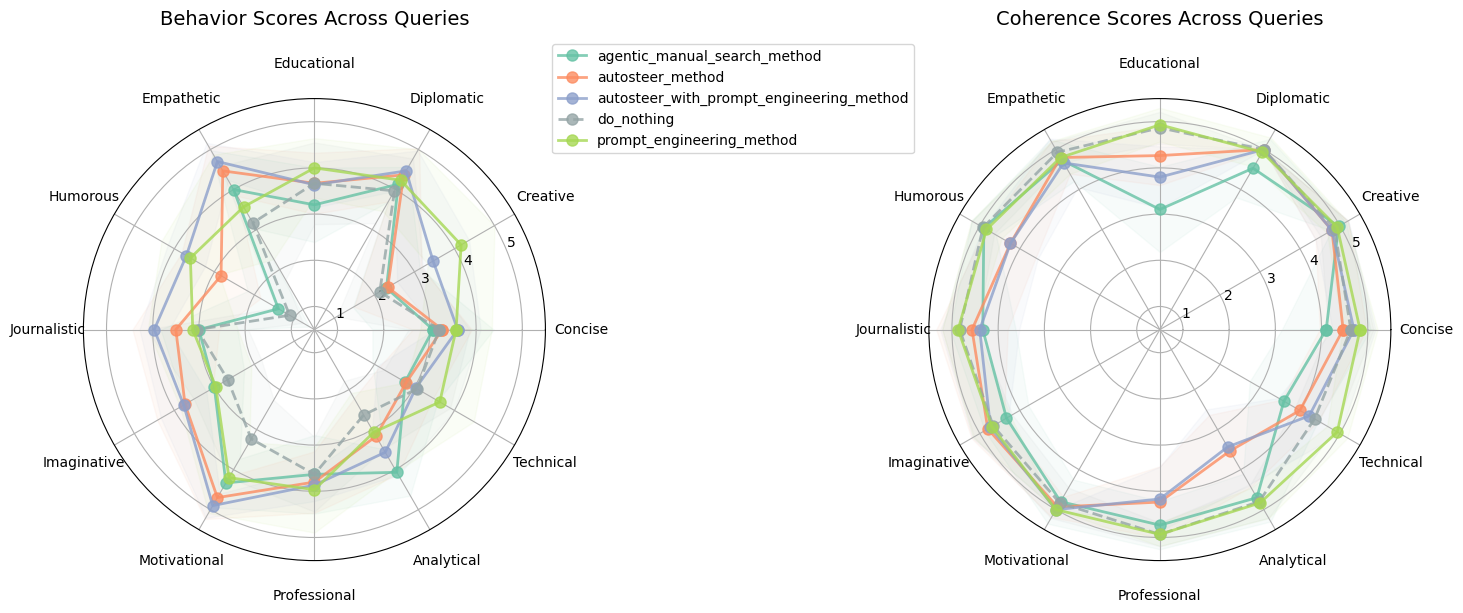

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/1678440987.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='steering_method', y=metric, ax=ax,
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/1678440987.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/1678440987.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='steering_method', y=metric, ax=ax,
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/1678440987

Distribution plot saved to results/llama_3-1_8b_violin.jpg


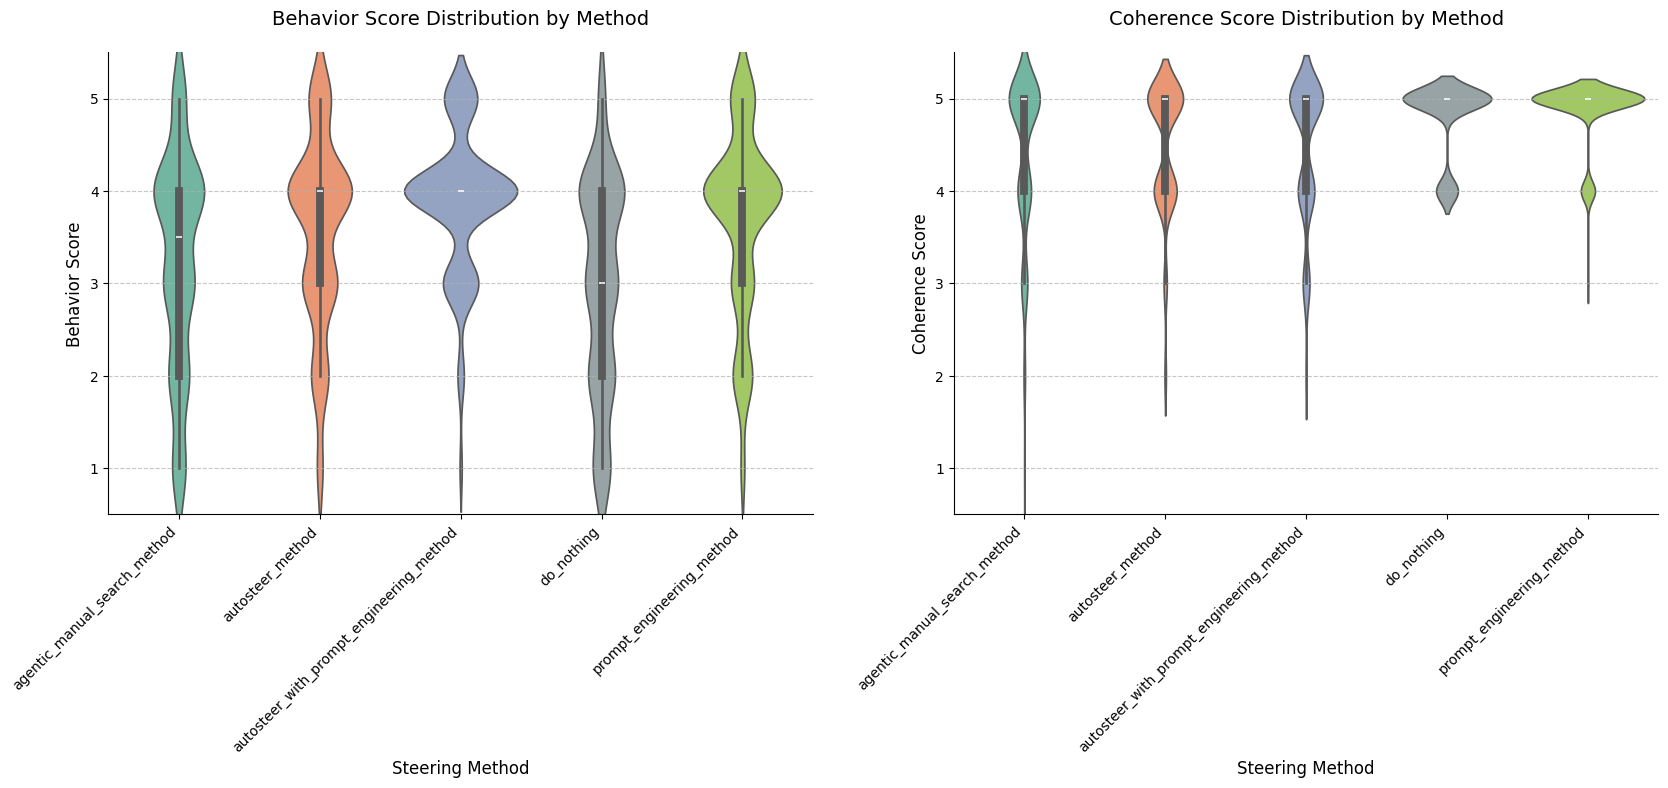

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/576833731.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_melted.groupby(['query', 'metric'])['score'].agg(['mean', 'std']).reset_index()
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/576833731.py:105: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/576833731.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats 

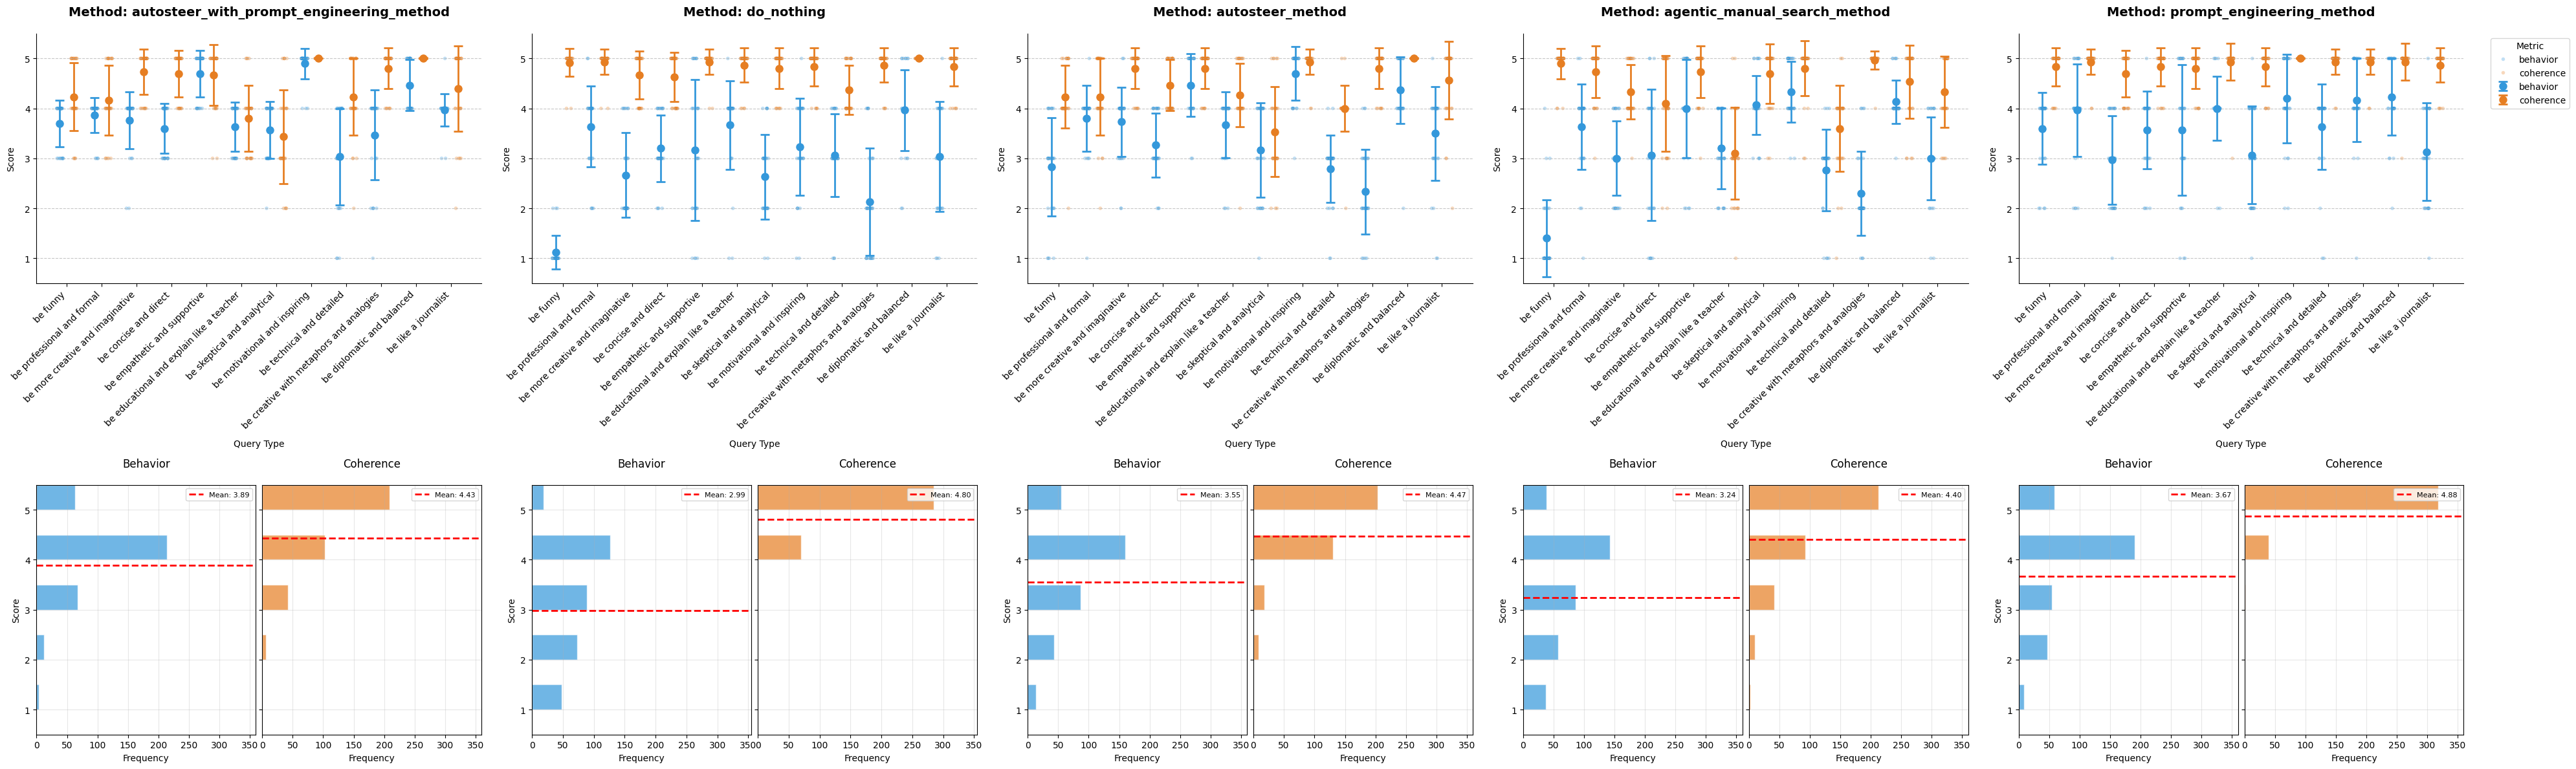

In [101]:
df = pd.read_csv('results/eval_gpt-4o-mini_var_llama-3.1_dt_20250123.csv')

plot_radar_comparison(df, save_path='results/llama_3-1_8b_radar.jpg')
plot_distribution_comparison(df, save_path='results/llama_3-1_8b_violin.jpg')
plot_all_methods(df)

### Llama-3.3

In [103]:
df = pd.read_csv('results/eval_gpt-4o-mini_var_llama-3.3_dt_20250124.csv')

Radar plot saved to results/llama_3-3_70b_radar.jpg


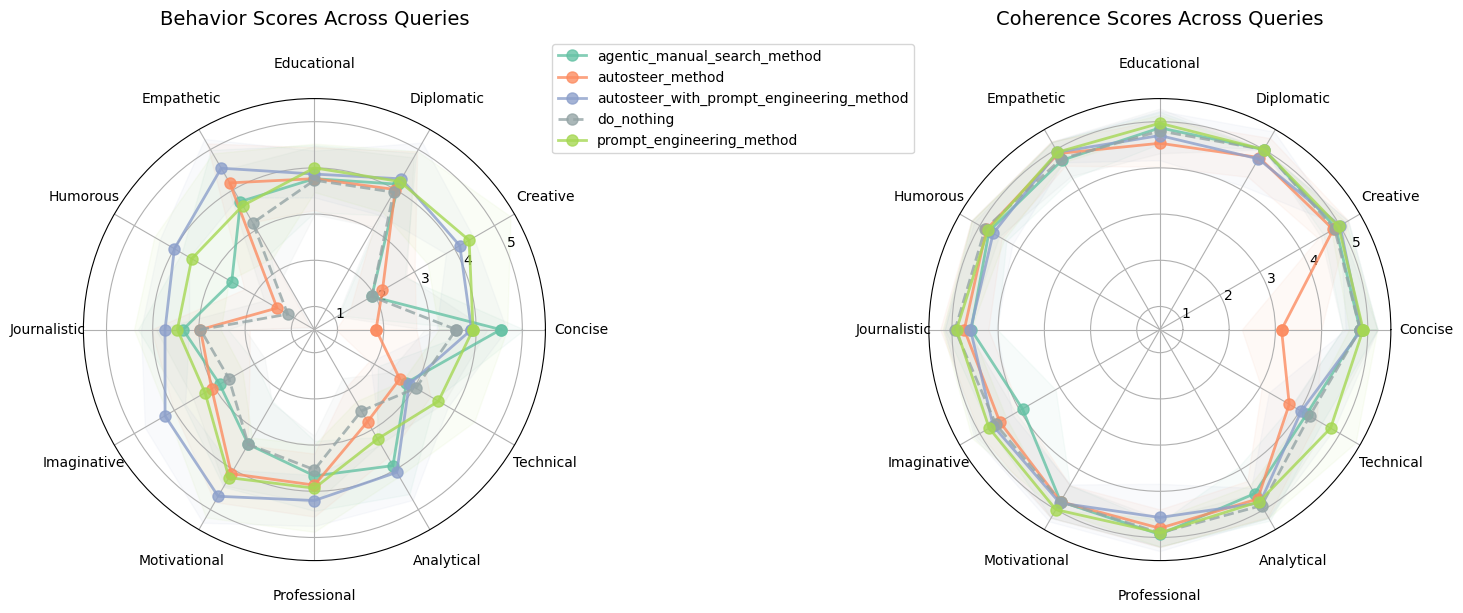

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/1678440987.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='steering_method', y=metric, ax=ax,
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/1678440987.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/1678440987.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='steering_method', y=metric, ax=ax,
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/1678440987

Distribution plot saved to results/llama_3-3_70b_violin.jpg


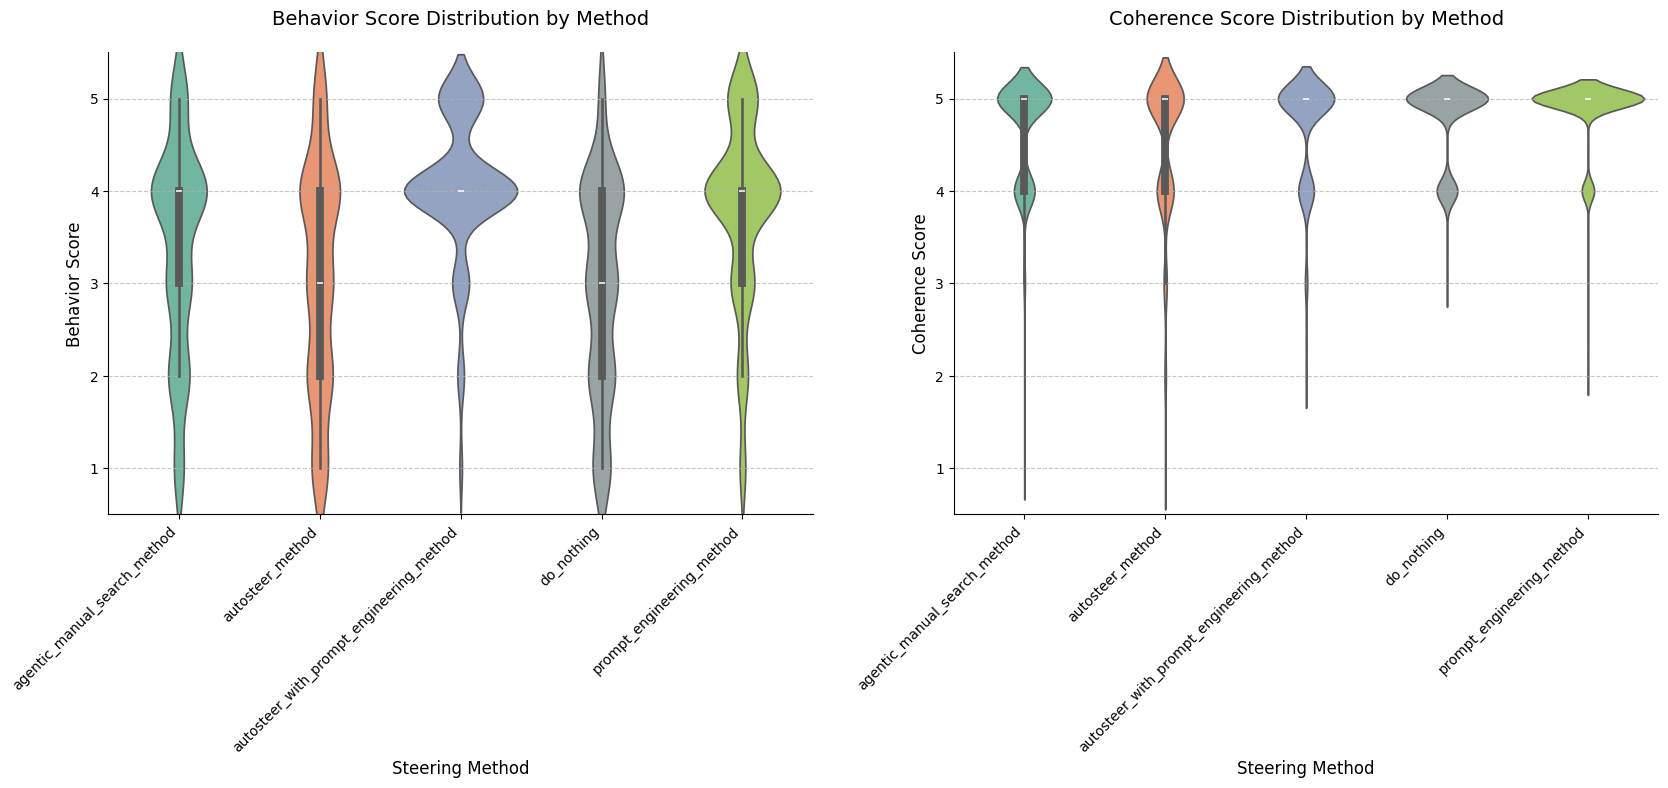

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/576833731.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_melted.groupby(['query', 'metric'])['score'].agg(['mean', 'std']).reset_index()
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/576833731.py:105: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_9982/576833731.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats 

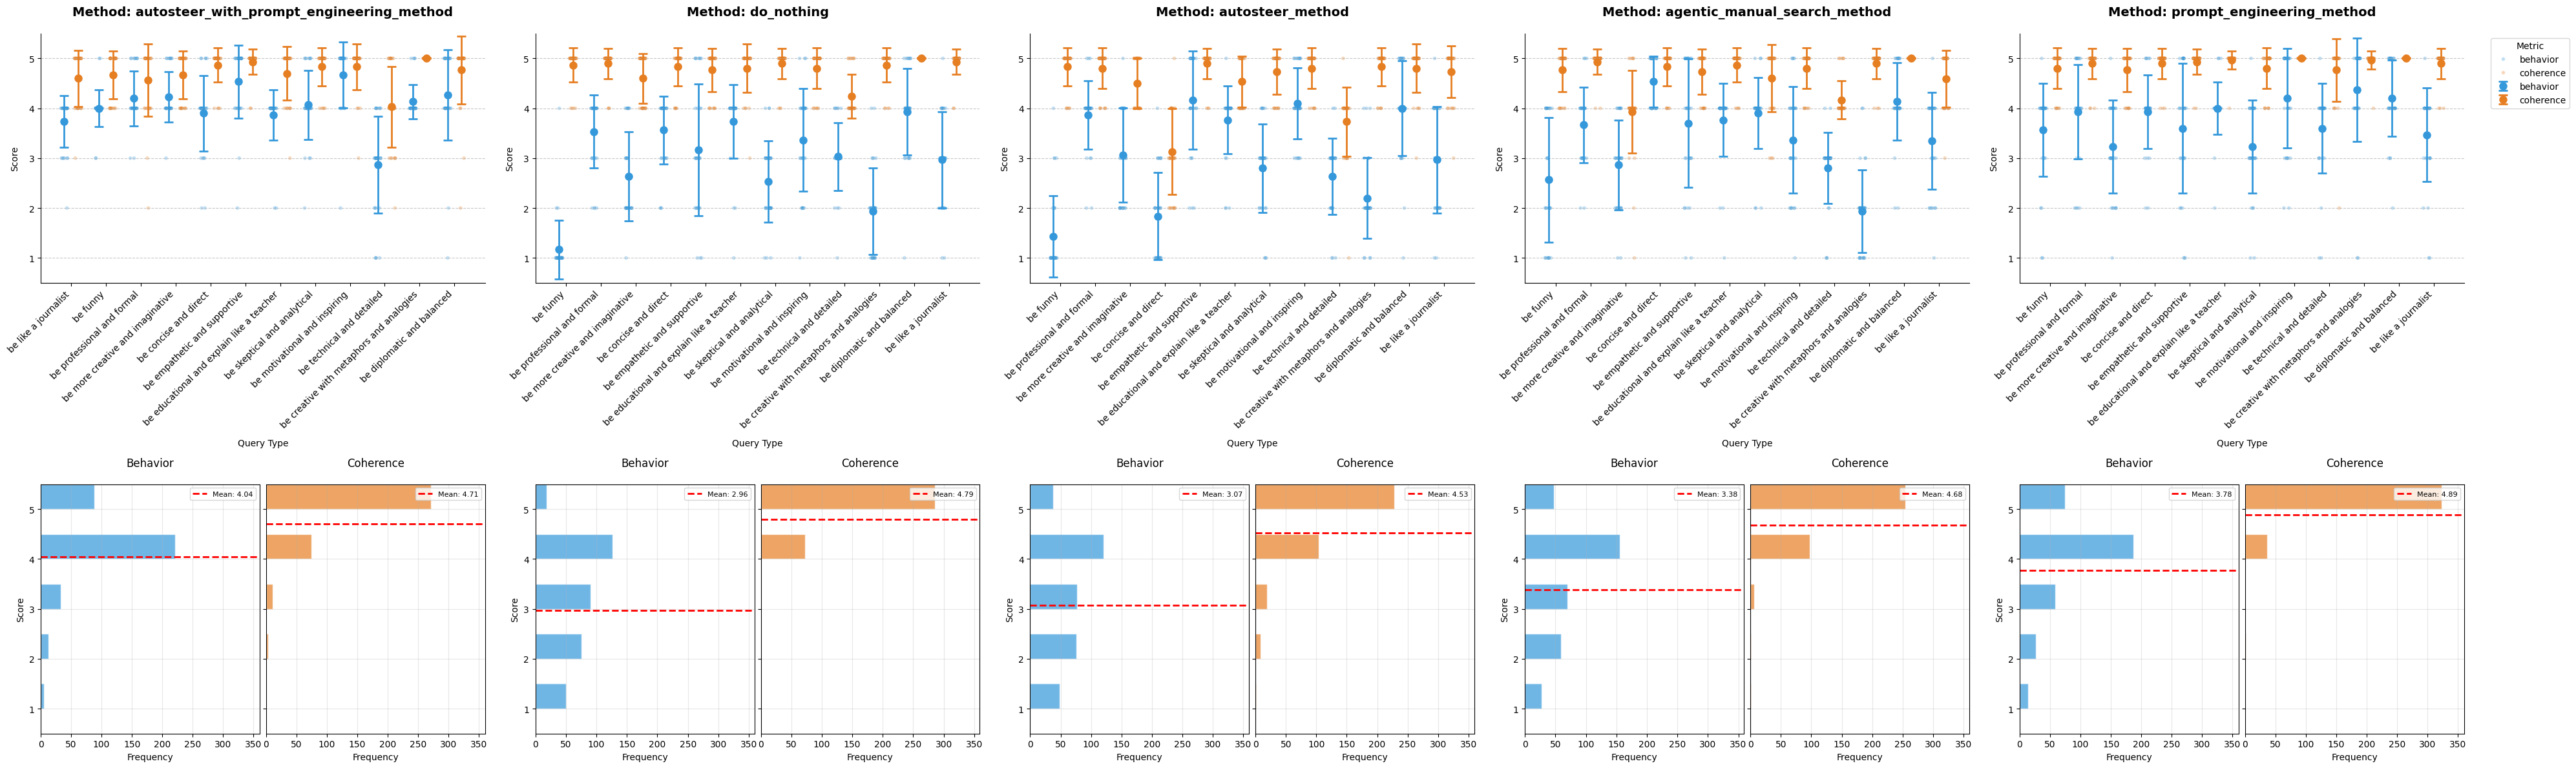

In [104]:
plot_radar_comparison(df, save_path='results/llama_3-3_70b_radar.jpg')
plot_distribution_comparison(df, save_path='results/llama_3-3_70b_violin.jpg')
plot_all_methods(df)

In [50]:
df[df['coherence'] < 2][['query', 'system_prompt', 'user_prompt', 'steering_method', 'response', 'analysis', 'behavior', 'coherence']]

query                 system_prompt  \
604         be technical and detailed  You are a helpful assistant.   
791  be more creative and imaginative  You are a helpful assistant.   

                        user_prompt               steering_method  \
604  Describe TCP/IP protocol stack              autosteer_method   
791  Building healthy relationships  agentic_manual_search_method   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [100]:
df[np.logical_and(df['behavior'] < 2, df['user_prompt'] == 'Create a casual greeting')][['query', 'system_prompt', 'user_prompt', 'steering_method', 'response', 'analysis', 'behavior', 'coherence']]

,query,system_prompt,user_prompt,steering_method,response,analysis,behavior,coherence
248,be technical and detailed,"When answering to the following prompt, be technical and detailed",Create a casual greeting,autosteer_with_prompt_engineering_method,Hello! It's nice to meet you. I'm here to help with any questions or tasks you have. What would you like to do first?,"The response is friendly and welcoming but lacks technical detail and specificity. It does not provide any technical information or depth related to a particular subject, which is necessary to achieve the desired behavior of being technical and detailed. The coherence of the response is good, as it is clear and easy to understand, but it does not meet the criteria for being technical.",1,4
603,be technical and detailed,You are a helpful assistant.,Create a casual greeting,do_nothing,Hey there! How's your day going so far?,"The response is informal and lacks technical detail, failing to address any specific topic or provide in-depth information. It is more of a casual greeting than a technical response, which does not meet the criteria for being technical and detailed. Additionally, it does not present any coherent ideas or arguments related to a technical subject.",1,4
963,be technical and detailed,You are a helpful assistant.,Create a casual greeting,autosteer_method,Hello! How can I help you today?,"The response is very general and lacks any technical detail or specificity. It does not provide any information or context that would be considered technical or detailed. Instead, it is a simple greeting that does not address any particular topic or question. Therefore, it does not achieve the desired behavior of being technical and detailed. However, the response is coherent as it is a clear and understandable greeting.",1,5
1322,be technical and detailed,You are a helpful assistant.,Create a casual greeting,agentic_manual_search_method,"Hello, how can I help you today?","The response is overly simplistic and does not provide any technical or detailed information. It merely offers a greeting without addressing any specific topic or inquiry, which fails to meet the criteria of being technical and detailed. Additionally, while the response is coherent in its structure, it lacks substance.",1,4
1682,be technical and detailed,"When answering to the following prompt, be technical and detailed",Create a casual greeting,prompt_engineering_method,"""Hey there, how's it going? I'm here to help with anything you need, so feel free to ask away!""","The response is informal and lacks technical detail, failing to provide any specific information or context that would be necessary for a technical evaluation. It does not address any particular topic or question, making it unsuitable for a technical discussion. The language used is casual and does not reflect a detailed or technical approach.",1,4


In [47]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df[df['query'] == 'be creative with metaphors and analogies'][['query', 'system_prompt', 'user_prompt', 'steering_method', 'response', 'analysis', 'behavior', 'coherence']].sample(10)

,query,system_prompt,user_prompt,steering_method,response,analysis,behavior,coherence
1363,be creative with metaphors and analogies,"When answering to the following prompt, be creative with metaphors and analogies",What causes earthquakes?,prompt_engineering_method,"Earthquakes are like a big release of pent-up energy, similar to when you finally pop a balloon that's been blown up too much. The Earth's crust is made up of huge plates that fit together like a jigsaw puzzle, and sometimes they get stuck. As they try to move past each other, they build up stress, like a rubber band being stretched to its limit. Eventually, the stress becomes too much, and the plates suddenly shift, releasing all that stored energy as seismic waves - and that's what we feel as an earthquake!","The response effectively uses metaphors and analogies to explain the concept of earthquakes. The comparison of earthquakes to popping a balloon and the analogy of the Earth's crust as a jigsaw puzzle are both creative and relatable. The imagery of a rubber band being stretched adds depth to the explanation of stress buildup. Overall, the response achieves a high level of creativity in its use of metaphors and analogies.",5,5
656,be creative with metaphors and analogies,You are a helpful assistant.,Explain blockchain technology,autosteer_method,"**Blockchain Technology:**\nA secure, transparent, and decentralized system where data (information) is stored, and once entered, it can't be altered. Here's how it works:\n\n* **Blocks of Data:** Information is gathered, verified, and added to a block.\n* **Linked Together:** Each block is connected to the previous one, creating a chain ( blockchain).\n* **Decentralized Network:** Many computers (nodes) work together to validate and update the chain.\n* **Secure and Transparent:** Each node has a copy of the entire chain, making it hard to alter or manipulate the data.\n\nThis technology enables secure, efficient, and reliable transactions, making it a foundation for various applications, including cryptocurrency, supply chain management, and more.","The response provides a clear and factual explanation of blockchain technology but lacks creativity in its use of metaphors and analogies. It presents the information in a straightforward manner without employing imaginative comparisons or vivid imagery that could enhance understanding or engagement. The coherence of the explanation is strong, as it logically outlines the components and functions of blockchain technology.",2,5
649,be creative with metaphors and analogies,You are a helpful assistant.,How do I start a garden?,autosteer_method,"Starting a garden can be exciting! To begin, you'll need to:\n\n1. **Choose a location**: Find a spot with good sunlight and water access.\n2. **Prepare the soil**: Test the pH level and add necessary nutrients.\n3. **Select the right plants**: Pick ones that fit your climate and skill level.\n4. **Plant seeds or seedlings**: Follow the instructions for each plant.\n5. **Nurture and maintain**: Water, prune, and fertilize regularly.\n\nWant more specific tips or help with a particular part of the process?","The response is straightforward and provides clear, practical steps for starting a garden. However, it lacks creativity in the use of metaphors and analogies, making it more of a procedural guide than an imaginative exploration of gardening. The language is functional but does not evoke vivid imagery or connections that would enhance the reader's experience. Therefore, it scores low on creativity while maintaining coherence throughout.",2,5
996,be creative with metaphors and analogies,You are a helpful assistant.,Write a technical specification,agentic_manual_search_method,"**Technical Specification Document**\n\n**Introduction:**\nThis document outlines the technical specifications for a complex system, ensuring that all stakeholders are aligned and working towards a common goal.\n\n**System Requirements:**\n\n1. **Hardware:**\n\

In [48]:
df.groupby('steering_method')['system_prompt'].value_counts()

steering_method               system_prompt                                                                    
agentic_manual_search_method  You are a helpful assistant.                                                         359
autosteer_method              You are a helpful assistant.                                                         360
do_nothing                    You are a helpful assistant.                                                         359
prompt_engineering_method     When answering to the following prompt, be concise and direct                         30
                              When answering to the following prompt, be creative with metaphors and analogies      30
                              When answering to the following prompt, be diplomatic and balanced                    30
                              When answering to the following prompt, be educational and explain like a teacher     30
                              When answering to the fol